# Pima Diabetes Dataset Analysis (98% Accuracy & 98% F1 Score)

### Using Keras(Dense Layer), Optuna(Hyperparameter optimization) & RFECV (Recursive Feature Elimination)


# Author
### Pradeep Gurav
##### https://www.linkedin.com/in/pradeepgurav/

#### November 26, 2020

##### How to get Pima Diabetes Analysis results > 98%
Most of the analysis/models results on Kaggle are around 78%. Piotr's Analysis Notebook which was the highest so far who had achieved 84% accuracy.

There are many notebooks describing Data exploration and understanding Pima Diabetes data, so will not cover that part in this report. From the data exploration, many of the features(such as Insulin, SkinThickness etc) had overlapping distribution over the outcomes(Diabetic-/NonDiabetic), so it was going to be hard relying on those features.

Tried many methods to improve the accuracy such as:

    1. Deleting records with zero values
    2. Imputing zero values using KNN, mean values
    3. Clipping extreme values or out of range values, bucketing certain features (Age, Pregnancies)
    4. Applying LogTransform so as to shift some of the feature's distribution towards Normal. No Good results.
    5. Many other imputing methods including my own method (Dense Layer network - regression values)
    6. Feature separation, using two separate models using diff features and concatenating the models
    7. And also using Optuna to try thousands of combinations of layers, Dense layer units, lr, batch sizes. Optuna is  a fantastic tool.
    8. Also used RFECV & PCA to identify most co-relating features
    9. What actually contributed the most to the performance is the 'Data Augmentation' method

The below code is self explanatory, here is the summary of steps:

    1. Splitted original data into 75:25. Saved both as CSVs again. The 25% dataset was not exposed to the model while training.
    2. Used 75% dataset(576 records) and added new 76992 records to the original dataset.
    3. Used Optuna hyperoptimization to get optimum layers and units.
    4. Saved the best model and used the same model once Optuna optimization was completed
    5. Used the 25% data kept aside for testing, which have 98% accuracy (same 98% for most classification parameters)
    6. This model could lead to accuracy above 99% with a bit more effort
       
Data files used:

    1. Public known data      ../input/pima-indians-diabetes-database/diabetes.csv
    2. file with 100 times    ../input/multiples/diabetes75pc_100_times.csv
    3. 25% testdata unsued in training    ../input/multiples/diabetes25pc.csv

In [2]:
#!pip install optuna
from __future__ import absolute_import, division, print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.backend import clear_session
from keras.optimizers import RMSprop, Adam
from keras import regularizers

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import seaborn as sns
import optuna
from optuna.integration import TFKerasPruningCallback

from subprocess import check_output
import time
import warnings

import os
import sys

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/kaggle/input/pima-indians-diabetes-database/diabetes.csv
/kaggle/input/multiples/diabetes25pc.csv
/kaggle/input/multiples/diabetes75pc_50_times.csv
/kaggle/input/multiples/diabetes75pc_100_times.csv


In [3]:
#This runtime value is used by Optuna to run the permutations required for hyper-parameter optimizations. 
#The results in this report were achieved over 1 hour run of the Optuna code.
runtime = 360

In [6]:
data = pd.read_csv("../input/multiples/diabetes75pc_100_times.csv")

'''
# The below code shows how I split the original data to 75:25 ratio
# I wrote a function to fabricate (any number of) new records as "multiplydata_pcversion" function

ori = pd.read_csv("../input/pima-indians-diabetes-database/diabetes.csv")

Train_data = ori[:576]
Test_data = ori[576:]
Test_data.shape[0]

trainfile = "C://Users//pg//Documents//datascience//case studies//pima//data//diabetes75pc.csv"
testfile = "C://Users//pg//Documents//datascience//case studies//pima//data//diabetes25pc.csv"
Train_data.to_csv(trainfile, index=False, line_terminator='\n') 
#Output ->   ../input/multiples/diabetes75pc_100_times.csv
Test_data.to_csv(testfile, index=False, line_terminator='\n') 
#Output ->   ../input/multiples/diabetes25pc.csv

multiple = 50
multiplydata_pcversion(multiple,trainfile)
'''
print("Check the number of records:  ", data.shape)
data.head()

Check the number of records:   (77568, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,4,129,70,18,122,29.43,1.17,45,1
1,1,205,76,36,249,37.28,0.92,29,1
2,8,97,82,0,0,37.82,0.59,68,0
3,7,141,90,41,0,34.25,0.40,39,0
4,4,120,72,0,0,29.12,0.39,46,1


### Data Exploration

The below heatmap shows correlation among all the features and the Outcome.

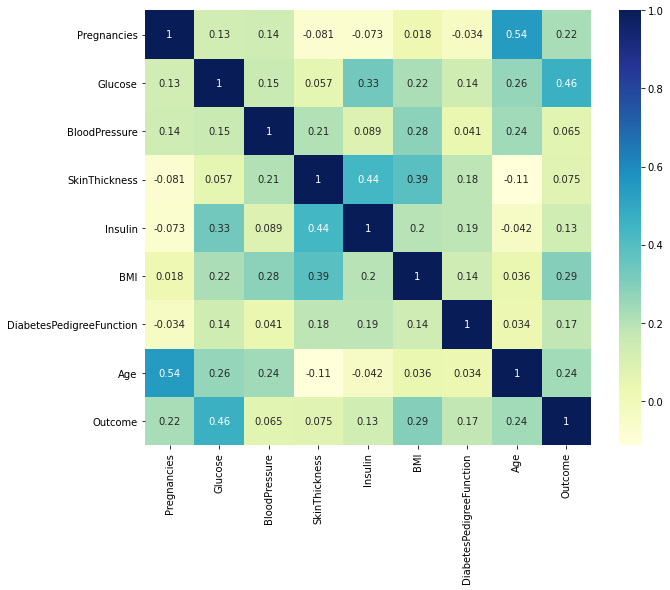

In [7]:
sns.heatmap(data.corr(),annot=True, cmap = 'YlGnBu')
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.show()

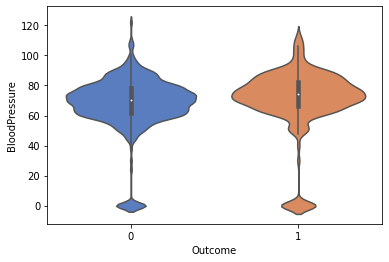

In [8]:
ax = sns.violinplot(x='Outcome', y='BloodPressure', data=data, palette='muted', split=True)

From the above plot we can see that BloodPressure has hardly any effect on the Outcome(Diabetic/NonDiabetic). So we can easily drop similar other features from our model.

In [9]:
pdata = data.copy(deep=True)
feature_names = pdata.columns[:8]
X = pdata[feature_names]
y = pdata.Outcome

# Features chosen based on RFECV result
best_features = ['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction']
X = StandardScaler().fit_transform(X[best_features])
# Splitting  data into training and testing (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20
)

In [10]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

study_name = "PIMAFeatureEng"
checkpoint_path = './Pima26Nov.hdf5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# create checkpoint callback
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                              monitor='val_accuracy',
                                              save_weights_only=False,
                                              save_best_only=True,
                                              verbose=0
                                             )

with tpu_strategy.scope():           
    def objective(trial):
        # Clear clutter from previous Keras session graphs.
        clear_session()

        num_epochs = 100
            # Create callbacks for early stopping and pruning.
        callbacks = [
            keras.callbacks.EarlyStopping(patience=3),
            TFKerasPruningCallback(trial, "val_accuracy"),
            cp_callback
        ]    
        model = Sequential()
        for i in range(3):                        
            model.add(Dense(int(trial.suggest_discrete_uniform(
                'FC_{}_num_hidden_units'.format(i), 16, 80, 4)),
                            activation = "relu",
                            input_dim=4
                           )
                     )              
        model.add(Dense(1, activation = 'sigmoid'))
        lr = trial.suggest_uniform("lr", 1e-4, 1e-1)
        model.compile(loss = 'binary_crossentropy', optimizer = Adam(lr=lr), metrics=['accuracy'])
        batch_size = trial.suggest_int('Batch_size', 32, 128, 16) 
        history = model.fit(X_train, 
                           y_train,
                           validation_data= (X_test, y_test),
                           epochs=num_epochs,
                           batch_size = batch_size,
                           callbacks=callbacks,
                           verbose=0
                           )
        score = model.evaluate(X_test, y_test, verbose=0)
        return score[1]

In [11]:
tic = time.process_time()
#The below line is important to see the logs while Optuna optimization
optuna.logging.disable_default_handler()
study = optuna.create_study(
        sampler=optuna.samplers.TPESampler(
            consider_prior=True, prior_weight=1.0, 
            consider_magic_clip=True, consider_endpoints=False, 
            n_startup_trials=10, n_ei_candidates=24, 
            seed=None), 
        pruner=optuna.pruners.SuccessiveHalvingPruner(
            min_resource=2, reduction_factor=4, min_early_stopping_rate=1),
        study_name = study_name, 
        direction="maximize",
)

#study.optimize(objective, n_trials=100, timeout=600)
study.optimize(objective, timeout=runtime)

toc = time.process_time()
print("time taken :  ")
print(toc-tic)
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial number:", study.best_trial.number)
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    

time taken :  
427.319769196
Number of finished trials: 43
Best trial number: 15
  Value: 0.9845945835113525
  Params: 
    FC_0_num_hidden_units: 36.0
    FC_1_num_hidden_units: 56.0
    FC_2_num_hidden_units: 40.0
    lr: 0.008343112873882182
    Batch_size: 96


In [12]:
#ls {checkpoint_path}
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./Pima26Nov.hdf5
./__notebook_source__.ipynb


In [13]:
optuna.visualization.plot_intermediate_values(study)

In [14]:
optuna.visualization.plot_parallel_coordinate(study)

In [15]:
#Load the optimized model which is saved at checkpoint_path
print(checkpoint_path)
new_model = keras.models.load_model(checkpoint_path)
new_model.summary()

./Pima26Nov.hdf5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 36)                180       
_________________________________________________________________
dense_1 (Dense)              (None, 56)                2072      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2280      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
Total params: 4,573
Trainable params: 4,573
Non-trainable params: 0
_________________________________________________________________


In [16]:
scores = new_model.evaluate(X_test, y_test)
py_pred  = new_model.predict(X_test)
py_pred = np.where(py_pred > 0.5, 1, 0) #py_pred = py_pred.round()
print("Accuracy of the training", scores[1]*100)

485/485 [==============================] - 4s 8ms/step - loss: 0.0356 - accuracy: 0.9865
Accuracy of the training 98.64638447761536


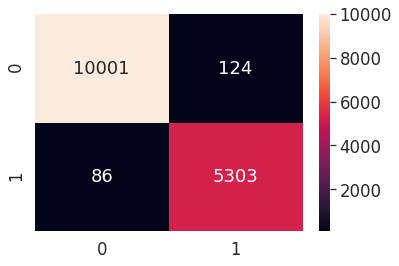

In [17]:
cm = confusion_matrix(y_test, py_pred)

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes =True)
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

Confusion Matrix shows True Positives, True Negatives, False Positives(FP) and False Negatives(FN). 0 FPs and 0 FNs is the ideal outcome.

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report

print('Accuracy: {:.2f}%'.format(accuracy_score(y_test, py_pred) * 100))
print('Classification report:\n\n', classification_report(y_test, py_pred))


Accuracy: 98.65%
Classification report:

               precision    recall  f1-score   support

           0       0.99      0.99      0.99     10125
           1       0.98      0.98      0.98      5389

    accuracy                           0.99     15514
   macro avg       0.98      0.99      0.99     15514
weighted avg       0.99      0.99      0.99     15514



In [19]:
# Load the test data which was kept aside in the beginning
test = pd.read_csv("../input/multiples/diabetes25pc.csv")
best_features = ['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction']
X1 = StandardScaler().fit_transform(test[best_features])
y1 = test.Outcome

In [20]:
py_pred1  = new_model.predict(X1)
py_pred1 = np.where(py_pred1 > 0.5, 1, 0) #py_pred = py_pred.round()

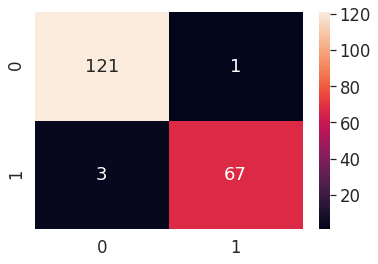

In [21]:
cm = confusion_matrix(y1, py_pred1)

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes =True)
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

In [22]:
print('Accuracy: {:.2f}%'.format(accuracy_score(y1, py_pred1) * 100))
print('Classification report:\n\n', classification_report(y1, py_pred1))

Accuracy: 97.92%
Classification report:

               precision    recall  f1-score   support

           0       0.98      0.99      0.98       122
           1       0.99      0.96      0.97        70

    accuracy                           0.98       192
   macro avg       0.98      0.97      0.98       192
weighted avg       0.98      0.98      0.98       192



### Discussion on Results achieved

1. The report describes various methods tried to optimize the results
2. It provides a framework which uses various tools and techniques to solve similar problems
3. There is significant jump in accuracy improvement from 84% to 98%

    
### References /Acknowledgements

####  1. Notebook by Piotr Tynecki on Pima Dataset:->    https://www.kaggle.com/ptynecki/pima-indians-diabetes-prediction-with-lr-84



####  2. Optuna - used for hyperparameter optimization:->    https://optuna.org/



####  3. Kaggle - Thanks for providing this fantastic platform and allowing to use GPUs/TPUs